In [ ]:
# ! pip install torch==1.13.1
# !pip install transformers==4.17

In [1]:
!pip install -q -U datasets transformers evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes)
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
roc_auc_metric = evaluate.load("roc_auc")

In [4]:
# check dataset
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 4500
})

In [5]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

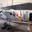

In [6]:
train_ds[0]['img']

In [7]:
train_ds[0]['label']

0

In [8]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [9]:
id2label[train_ds[0]['label']]

'airplane'

In [10]:
# Data preprocessing
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [12]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [11]:
# Image transforms for preprocessing

from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [13]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [14]:
# image example
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [0, 4],
 'pixel_values': [tensor([[[ 0.6471,  0.6471,  0.6471,  ..., -0.1608, -0.1608, -0.1608],
           [ 0.6471,  0.6471,  0.6471,  ..., -0.1608, -0.1608, -0.1608],
           [ 0.6471,  0.6471,  0.6471,  ..., -0.1608, -0.1608, -0.1608],
           ...,
           [-0.1529, -0.1529, -0.1529,  ..., -0.4431, -0.4431, -0.4431],
           [-0.1529, -0.1529, -0.1529,  ..., -0.4431, -0.4431, -0.4431],
           [-0.1529, -0.1529, -0.1529,  ..., -0.4431, -0.4431, -0.4431]],
  
          [[ 0.5765,  0.5765,  0.5765,  ..., -0.1216, -0.1216, -0.1216],
           [ 0.5765,  0.5765,  0.5765,  ..., -0.1216, -0.1216, -0.1216],
           [ 0.5765,  0.5765,  0.5765,  ..., -0.1216, -0.1216, -0.1216],
           ...,
           [-0.2314, -0.2314, -0.2314,  ..., -0.5451, -0.5451, -0.5451],
           [-0.2314, -0.2314, -0.2314,  ..., -0.5451, -0.5451, -0.

In [15]:
# pytorch data loader
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [17]:
# transformer model
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [19]:
# computing metrics
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [20]:
# trainer
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [21]:
# train!
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.720730,0.968000
2,1.408200,0.430694,0.968000
3,0.663200,0.362265,0.966000


TrainOutput(global_step=1350, training_loss=0.9045918895580151, metrics={'train_runtime': 567.4268, 'train_samples_per_second': 23.792, 'train_steps_per_second': 2.379, 'total_flos': 1.046216869705728e+18, 'train_loss': 0.9045918895580151, 'epoch': 3.0})

In [22]:
# Let's check the performance on the test set
outputs = trainer.predict(test_ds)

In [23]:
print(outputs.metrics)

{'test_loss': 0.7371166944503784, 'test_accuracy': 0.959, 'test_runtime': 28.9809, 'test_samples_per_second': 69.011, 'test_steps_per_second': 17.253}


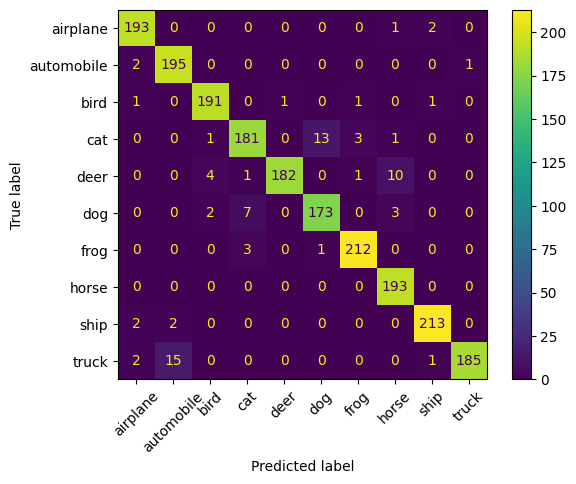

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)